In [1]:
### load modules 
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sim import get_indiv_sub_prt_omniscent 

plt.rcParams["figure.figsize"] = (20,10)
sns.set_context('paper',font_scale=2)
plt.rcParams["lines.linewidth"] = 3

plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Verdana'
save_plots = True

In [2]:
def get_subject_data(df, sub):
    # Get data for this subject
    sub_data = df[df['sub_num'] == sub]
    
    # Get rewards for each planet
    rewards_by_planet = []
    current_planet = None
    planet_rewards = []
    
    # Loop through rows for this subject
    for _, row in sub_data.iterrows():
        if current_planet != row['planet_num']:
            if planet_rewards:  # If we have rewards for previous planet
                rewards_by_planet.append(planet_rewards)
            current_planet = row['planet_num']
            planet_rewards = [row['reward']]
        else:
            planet_rewards.append(row['reward'])
    
    # Append final planet's rewards
    if planet_rewards:
        rewards_by_planet.append(planet_rewards)
        
    # Get galaxy for each planet
    galaxies = sub_data.groupby('planet_num')['galaxy'].first().tolist()
    
    # Get PRT (max stay_num) for each planet
    prt = sub_data.groupby('planet_num')['stay_num'].max().tolist() 
    prt = [x+1 for x in prt]
    
    return rewards_by_planet, galaxies, prt

def process_subject_data(df):
    # Initialize DataFrame to store aggregated results
    output = []

    # Process data for each simulated subject
    for sub_num in range(1, 101):
        # Get subject's reward trajectories, galaxy assignments, and PRTs
        rewards, galaxies, prts = get_subject_data(df, sub_num)
        
        # Calculate optimal PRTs and other metrics
        opt_prts, gems_per_dig, opt_gems_per_dig, opptun_cost, leave_thresh = get_indiv_sub_prt_omniscent(galaxies, rewards)
        
        # Calculate PRT relative to optimal
        prt_rel_om = [actual - optimal for actual, optimal in zip(prts, opt_prts)]
        
        # Create DataFrame for this subject's data
        subject_data = pd.DataFrame({
            "sub_num": sub_num,
            "galaxy": galaxies,
            "prt_rel_om": prt_rel_om,
            "prt": prts,
            "opt_prt": opt_prts
        })
        
        # Calculate mean values per galaxy type for this subject
        avg_subject = subject_data.groupby("galaxy").mean().reset_index()
        output.append(avg_subject)

    # Combine all subjects' data
    return pd.concat(output, ignore_index=True)


In [3]:
# Load simulated data for structure learner model
df = pd.read_csv("results/model_predictions/simulated_data_structure_learner.csv")
struc_learner = process_subject_data(df)
struc_learner=struc_learner.groupby("galaxy").mean().reset_index()

struc_learner_poor_opt = struc_learner[struc_learner.galaxy == 0].opt_prt.values[0]
struc_learner_neut_opt = struc_learner[struc_learner.galaxy == 1].opt_prt.values[0]
struc_learner_rich_opt = struc_learner[struc_learner.galaxy == 2].opt_prt.values[0]

struc_learner_poor_prt = struc_learner[struc_learner.galaxy == 0].prt.values[0]
struc_learner_neut_prt = struc_learner[struc_learner.galaxy == 1].prt.values[0]
struc_learner_rich_prt = struc_learner[struc_learner.galaxy == 2].prt.values[0]

df = pd.read_csv("results/model_predictions/simulated_data_non_structure_learner.csv")
non_struc_learner = process_subject_data(df)
non_struc_learner.groupby("galaxy").mean().reset_index()

non_struc_learner_poor_opt = non_struc_learner[non_struc_learner.galaxy == 0].opt_prt.values[0]
non_struc_learner_neut_opt = non_struc_learner[non_struc_learner.galaxy == 1].opt_prt.values[0]
non_struc_learner_rich_opt = non_struc_learner[non_struc_learner.galaxy == 2].opt_prt.values[0]

non_struc_learner_poor_prt = non_struc_learner[non_struc_learner.galaxy == 0].prt.values[0]
non_struc_learner_neut_prt = non_struc_learner[non_struc_learner.galaxy == 1].prt.values[0]
non_struc_learner_rich_prt = non_struc_learner[non_struc_learner.galaxy == 2].prt.values[0]


In [4]:
pal = sns.color_palette("Paired")
rbg_pal = [pal[5],pal[1],pal[3]]

/var/folders/8d/qdt_mh0j1wz9k9rkvpqk7zv00000gq/T/ipykernel_2040/1892117962.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g=sns.pointplot(x="prt",y="galaxy",ci=95,scale=3, palette=[rbg_pal[2],rbg_pal[1],rbg_pal[0]], order=['rich','neutral','poor'],markers="d", data=model_sims)


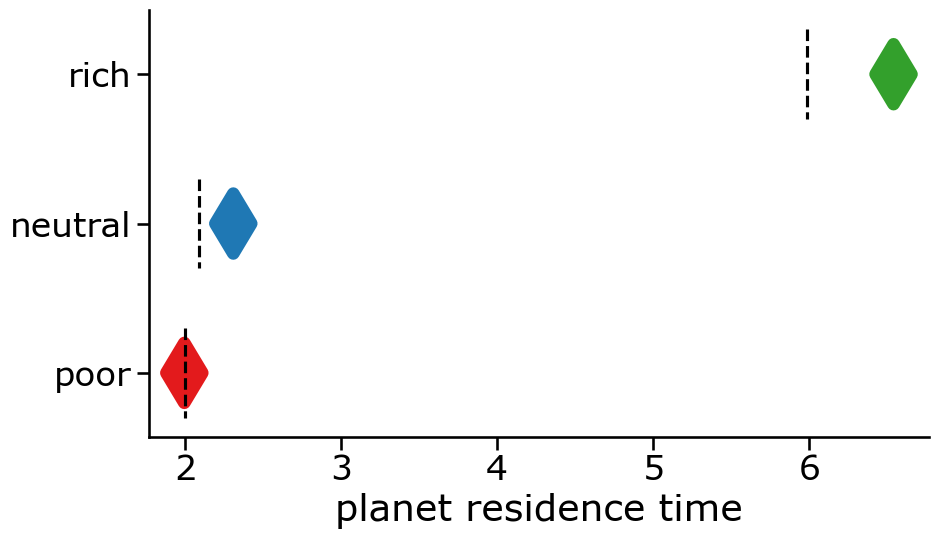

In [5]:
sns.set_context('talk',font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,6)
model_sims = pd.DataFrame({"galaxy":['poor','neutral','rich'],"prt":[struc_learner_poor_prt,struc_learner_neut_prt,struc_learner_rich_prt]})
g=sns.pointplot(x="prt",y="galaxy",ci=95,scale=3, palette=[rbg_pal[2],rbg_pal[1],rbg_pal[0]], order=['rich','neutral','poor'],markers="d", data=model_sims)
g.set_xlabel("planet residence time")
g.set_ylabel("")

plt.plot([struc_learner_poor_opt,struc_learner_poor_opt],[1.7,2.3],'k--')
plt.plot([struc_learner_neut_opt,struc_learner_neut_opt],[0.7,1.3],'k--')
plt.plot([struc_learner_rich_opt,struc_learner_rich_opt],[-0.3,0.3],'k--')
# plt.ylim([0,7])
sns.despine(top=True,right=True)
plt.tight_layout()  # Adjust layout to reduce white space

if save_plots:
    plt.savefig("plots/structure_learner_model_pred.png",transparent=True,dpi=300,bbox_inches="tight")

/var/folders/8d/qdt_mh0j1wz9k9rkvpqk7zv00000gq/T/ipykernel_2040/3650770738.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g=sns.pointplot(x="prt",y="galaxy",ci=95,scale=3, palette=sns.color_palette("Greys_r",5), order=['rich','neutral','poor'], markers="d",data=model_sims)


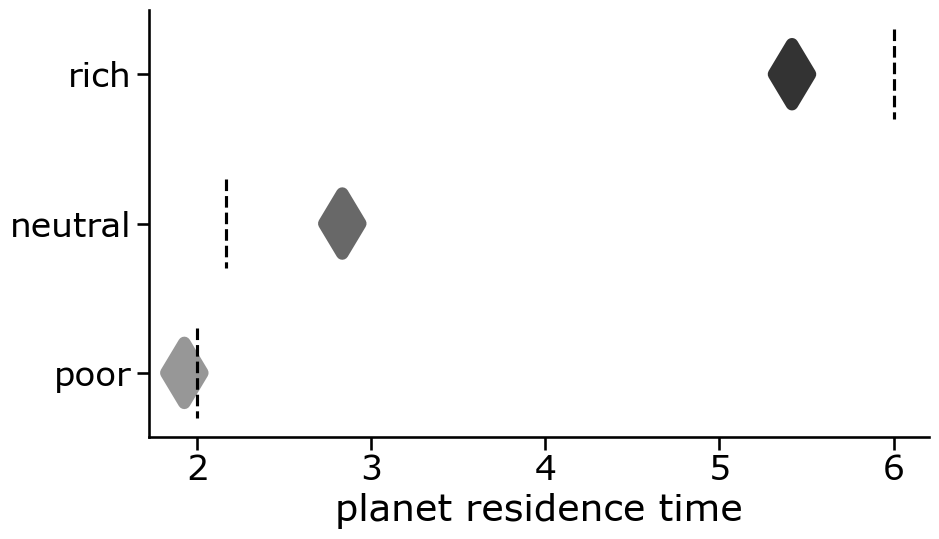

In [6]:
model_sims = pd.DataFrame({"galaxy":['poor','neutral','rich'],"prt":[non_struc_learner_poor_prt,
                                                                     non_struc_learner_neut_prt,
                                                                     non_struc_learner_rich_prt]})

g=sns.pointplot(x="prt",y="galaxy",ci=95,scale=3, palette=sns.color_palette("Greys_r",5), order=['rich','neutral','poor'], markers="d",data=model_sims)
g.set_xlabel("planet residence time")
g.set_ylabel("")

plt.plot([non_struc_learner_poor_opt,non_struc_learner_poor_opt],[1.7,2.3],'k--')
plt.plot([non_struc_learner_neut_opt,non_struc_learner_neut_opt],[0.7,1.3],'k--')
plt.plot([non_struc_learner_rich_opt,non_struc_learner_rich_opt],[-0.3,0.3],'k--')
sns.despine(top=True,right=True)
plt.tight_layout()  # Adjust layout to reduce white space

if save_plots:
    plt.savefig("plots/non_structure_learner_model_pred.png",dpi=300,transparent=True,bbox_inches="tight")

In [7]:
def get_switch_type(planet_num, curr_planet_type, data):
    if planet_num > 0:
        last_planet_type = data.query("planet==@planet_num-1").reset_index().galaxy[0]
        
        if int(last_planet_type == curr_planet_type):
            return 'no_switch'
        else:
            return 'switch'
    else:
        return 'no_switch'



def process_subject_switch_data(df):
    # Initialize DataFrame to store aggregated results
    output = []

    # Process data for each simulated subject
    for sub_num in range(1, 101):
        # Get subject's reward trajectories, galaxy assignments, and PRTs
        rewards, galaxies, prts = get_subject_data(df, sub_num)
        
        # Calculate optimal PRTs and other metrics
        opt_prts, gems_per_dig, opt_gems_per_dig, opptun_cost, leave_thresh = get_indiv_sub_prt_omniscent(galaxies, rewards)
        
        # Calculate PRT relative to optimal
        prt_rel_om = [actual - optimal for actual, optimal in zip(prts, opt_prts)]

        # Create DataFrame for this subject's data
        subject_data = pd.DataFrame({
            "sub_num": sub_num,
            "planet": range(len(prts)),
            "galaxy": galaxies,
            "prt_rel_om": prt_rel_om,
            "prt": prts,
            "opt_prt": opt_prts
        })

        # Add switch type for each planet
        switches = []
        for idx, row in subject_data.iterrows():
            planet_num = idx
            curr_planet_type = row['galaxy']
            switch_type = get_switch_type(planet_num, curr_planet_type, subject_data)
            switches.append(switch_type)
            
        subject_data['switch'] = switches

        # Calculate mean values per galaxy type for this subject
        avg_subject = subject_data.groupby("switch").mean().reset_index()
        output.append(avg_subject)

    # Combine all subjects' data
    return pd.concat(output, ignore_index=True)

In [10]:
# Load simulated data for structure learner model
df = pd.read_csv("results/model_predictions/simulated_data_uncertainty_adapter.csv")
uncertainty_adaptor = process_subject_switch_data(df)
uncertainty_adaptor=uncertainty_adaptor.groupby("switch").mean().reset_index()

uncertainty_adaptor_no_switch_opt = uncertainty_adaptor[uncertainty_adaptor.switch == 'no_switch'].opt_prt.values[0]
uncertainty_adaptor_switch_opt = uncertainty_adaptor[uncertainty_adaptor.switch == 'switch'].opt_prt.values[0]

uncertainty_adaptor_no_switch_prt = uncertainty_adaptor[uncertainty_adaptor.switch == 'no_switch'].prt.values[0]
uncertainty_adaptor_switch_prt = uncertainty_adaptor[uncertainty_adaptor.switch == 'switch'].prt.values[0]

# Load simulated data for structure learner model
df = pd.read_csv("results/model_predictions/simulated_data_uncertainty_non_adapter.csv")
uncertainty_non_adaptor = process_subject_switch_data(df)
uncertainty_non_adaptor=uncertainty_non_adaptor.groupby("switch").mean().reset_index()

uncertainty_non_adaptor_no_switch_opt = uncertainty_non_adaptor[uncertainty_non_adaptor.switch == 'no_switch'].opt_prt.values[0]
uncertainty_non_adaptor_switch_opt = uncertainty_non_adaptor[uncertainty_non_adaptor.switch == 'switch'].opt_prt.values[0]

uncertainty_non_adaptor_no_switch_prt = uncertainty_non_adaptor[uncertainty_non_adaptor.switch == 'no_switch'].prt.values[0]
uncertainty_non_adaptor_switch_prt = uncertainty_non_adaptor[uncertainty_non_adaptor.switch == 'switch'].prt.values[0]



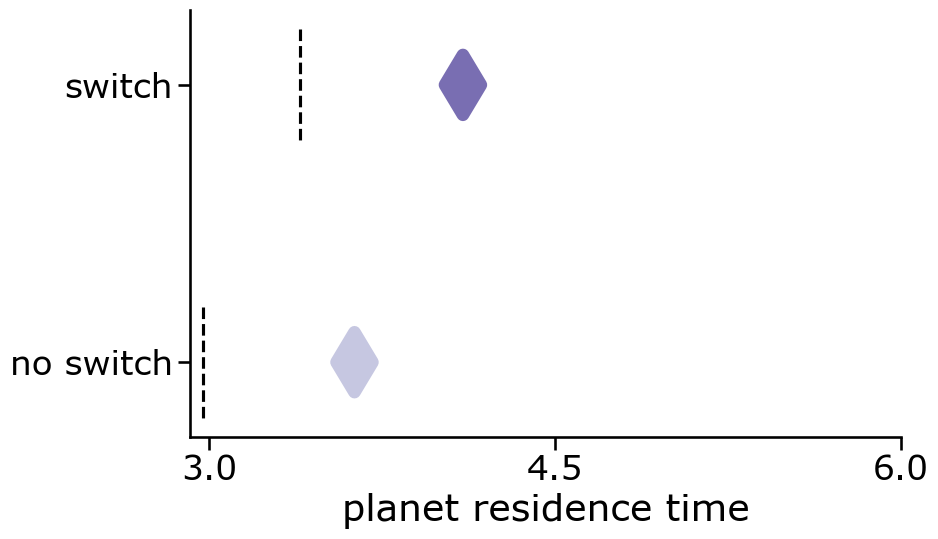

In [11]:
sns.set_context('talk',font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,6)
model_sims = pd.DataFrame({"switch":['no switch','switch'],"prt":[uncertainty_adaptor_no_switch_prt, 
                                                                  uncertainty_adaptor_switch_prt]})

g=sns.pointplot(x="prt",y="switch",palette="Purples_r",order=['switch','no switch'],scale=3,markers="d",data=model_sims)
g.set_xlabel("planet residence time")
g.set_ylabel("")
plt.plot([uncertainty_adaptor_switch_opt,uncertainty_adaptor_switch_opt],[-0.2,0.2],    'k--')
plt.plot([uncertainty_adaptor_no_switch_opt,uncertainty_adaptor_no_switch_opt],[0.8,1.2],'k--')

# plt.xlim([3,6])
plt.xticks([3,4.5,6])
sns.despine(top=True,right=True)
plt.tight_layout()  # Adjust layout to reduce white space
if save_plots:
    plt.savefig("plots/uncertainty_adaptor_model_pred.png",dpi=300,transparent=True,bbox_inches="tight")

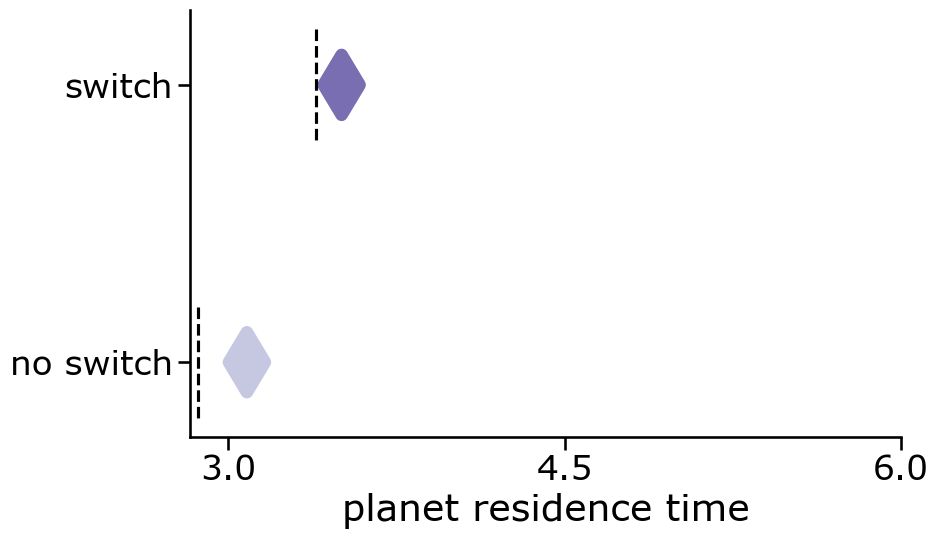

In [9]:
model_sims = pd.DataFrame({"switch":['no switch','switch'],"prt":[uncertainty_non_adaptor_no_switch_prt,
                                                                  uncertainty_non_adaptor_switch_prt]})

g=sns.pointplot(x="prt",y="switch",palette="Purples_r",order=['switch','no switch'],scale=3,markers="d",data=model_sims)
g.set_xlabel("planet residence time")
g.set_ylabel("")
plt.plot([uncertainty_non_adaptor_switch_opt,uncertainty_non_adaptor_switch_opt],[-0.2,0.2],    'k--')
plt.plot([uncertainty_non_adaptor_no_switch_opt,uncertainty_non_adaptor_no_switch_opt],[0.8,1.2],'k--')

# plt.xlim([3,6])
plt.xticks([3,4.5,6])
sns.despine(top=True,right=True)

plt.tight_layout()  # Adjust layout to reduce white space
if save_plots:
    plt.savefig("plots/non_uncertainty_adaptor_model_pred.png",dpi=300,transparent=True,bbox_inches="tight")